## RNA-Seq Differential Expression (DE) Analysis using edgeR
    Chen, Y, Lun, ATL, and Smyth, GK (2016). From reads to genes to pathways: differential expression analysis of RNA-Seq experiments using Rsubread and the edgeR quasi-likelihood pipeline. F1000Research 5, 1438.

    McCarthy DJ, Chen Y, Smyth GK (2012). “Differential expression analysis of multifactor RNA-Seq experiments with respect to biological variation.” Nucleic Acids Research, 40(10), 4288-4297. doi: 10.1093/nar/gks042.

    Robinson MD, McCarthy DJ, Smyth GK (2010). “edgeR: a Bioconductor package for differential expression analysis of digital gene expression data.” Bioinformatics, 26(1), 139-140. doi: 10.1093/bioinformatics/btp616.

We will be using the pasilla package for our example data which is cited here.

    Wolfgang Huber and Alejandro Reyes (2019). pasilla: Data package with per-exon and per-gene read counts of RNA-seq samples of Pasilla knock-down by Brooks et al., Genome Research 2011.. R package version 1.12.0.
  
Data for the package is part of this paper: 

    "Conservation of an RNA regulatory map between Drosophila and mammals" by Brooks AN, Yang L, Duff MO, Hansen KD, Park JW, Dudoit S, Brenner SE, Graveley BR, Genome Res. 2011 Feb;21(2):193-202, Epub 2010 Oct 4, PMID: 20921232. 

Briefly, edgeR uses a negative binomial distribution to determine the likelihood of differential expression between comparisons of two or more groups. This distribution mathematically accounts for the fact that we are assessing gene counts and we are assuming that most genes we are comparing between the groups will not be differentially expressed. The package is flexible in that it provides the user options to use empirical Bayes methods or frequentist methods which rely on the exact test, linear models, and quasi-likelihood tests. 

edgeR has wide range of applications to genomic analyses. Our simplified example describes the quasi-likeliehood F-test which is the method in edgeR which provides the strictest control of potential false positive genes.

###### Definition of terms
Quasi-likeliehood F Test:

Unadjusted p values vs adjusted p values/(FDR): In DE analysis, a single p-value tells you how likely it is that a single gene is differentially expressed between at least two groups (ex: a control and a treatment group) due to some actual difference between the groups as opposed to random chance. False Discovery Rate (FDR) tells you how likely it is that all genes identified as DE are false positives. A FDR of 5% means that among all genes called DE, an average of 5% of those are truly not DE.DE genes are only considered significantly so if they meet the adjusted p value, not only the unadjusted p value.

Our very first step is to load the edgeR and pasilla packages from Bioconductor. Please see http://bioconductor.org/ for information about installation and use of Bioconductor and its packages.

In [37]:
library("edgeR")
library("pasilla")

## Load our example data

Our example data are from the pasilla package available on Bioconductor. The experiment studied RNAi knockdown of Pasilla, the Drosophila melanogaster ortholog of mammalian NOVA1 and NOVA2, on the transcriptome. Data are provided by NCBI Gene Expression Omnibus under accession numbers GSM461176 to GSM461181.

Please reach out to EICC if you would like to compare 3 or more groups as this is a simplified example. It may also be the case that you will need more than 3-4 samples per experimental group or require different parameters for your project. Please see our PROPER walkthrough for an example of our of power and sample size analysis.

In [205]:
#read in the counts file and specify the variable name of the column of gene names in the file
countdata <- system.file("extdata",
                      "pasilla_gene_counts.tsv",
                      package="pasilla", mustWork=TRUE)

x <-as.matrix(read.delim(countdata, row.names=1))
head(x)

,untreated1,untreated2,untreated3,untreated4,treated1,treated2,treated3
FBgn0000003,0,0,0,0,0,0,1
FBgn0000008,92,161,76,70,140,88,70
FBgn0000014,5,1,0,0,4,0,0
FBgn0000015,0,2,1,2,1,0,0
FBgn0000017,4664,8714,3564,3150,6205,3072,3334
FBgn0000018,583,761,245,310,722,299,308


#### Labelling samples to create the group object

In our case, our replicates are organized in our count file above such that the first 4 columns are control samples and the latter 4 columns are treatment samples. This is how we label them in the group object. The group object specifies our two experimental group sof interest and importantly, it only tells us which columns are untreated and which are treated, it does not contain sample id numbers like 1,2 3, or 4 as this will cause problems in analysis.

In [206]:
group <- factor(c("untreated", "untreated", "untreated", "untreated",
                 "treated", "treated", "treated"))

## Preparation for Pairwise Differential Expression Analysis

In order to preform a pairwise comparison we need to specify some information about our data. In edgeR we must create a special object called a DGElist object, here abbreviated as y. This object takes in the x object and the group object to create the DGEList object and prepare for analysis. Since we want to know if edgeR filters out any additional genes with low counts, we create another object called y2 to perform additonal filtering and save the unfiltered DGElist object as y to see how many genes we are starting with and how many are filtered for low counts. 

Since edgeR looks at data alphabetically, we need to make sure we specify the untreated group is our reference group with the ref="untreated" statement.

In [207]:
y<-DGEList(counts=x, group=group)
y$samples$group <- relevel(y$samples$group, ref="untreated")
levels(y$samples$group) 
dim(y)
y2<-y

[1] "untreated" "treated"

[1] 14599     7

## Creating the design matrix

The design matrix is a mathematical representation of our experimental design. This is the way the quasi-likelihood F test needs to see our experiment represented in order to perform the comparsions we would like. 

Think of the first line like a simple linear equation: y= B0 + x*B1

y is our outcome of interest that we are expecting will vary based on the B0 and x*B1 terms. In our case y is gene expression.

~ 0 is our intercept term B0 and this tells us how much additional variability we have in our experiment if being either a case or a control had no effect on gene expression.

group is our variable of interest x*B1. We would like to calculate how much being in one group or another affects the expression of each gene.

The next two lines are renaming the column names of the design matrix to be the same as the levels in the samples, either "Control" or Treatment" inour case and the row names to be the sam as the column names in the cpm which are the IDs of our samples. 

In [208]:
design <-model.matrix(~0+group, data=y2$samples)
colnames(design) <- levels(y2$samples$group)
rownames(design) <-colnames(y2$counts)
design

,untreated,treated
untreated1,1,0
untreated2,1,0
untreated3,1,0
untreated4,1,0
treated1,0,1
treated2,0,1
treated3,0,1


## Gene filtering

Typically we want to ignore genes that have counts of zero across all samples since these are adding statistical noise. We may also want to be more stringent and remove genes with rows that sum to 10, 20 or even 30 or less since these could also be contributing statistical noise that would prevent us from seeing the differences between the cases and controls, especially if it is a small one. Think of it like removing the static from an analog TV. Once it's gone the picture is more clear.

For this example, we will use the filterbyExpr function to filter on counts per million (cpm) and let edgeR choose the filtering cutoff for us based on the data. We can even check how many genes were filtered at this step. We see that 6680 genes were filtered out and 7919 were kept in for analysis.

If you choose to use EICC and edgeR specifically to do your differential expression analysis, we do have the option to customize this part of the analysis based on your data and are able to filter more or fewer lowly expressed genes as needed. 

In [209]:
keep <- filterByExpr(y2)
table(keep)

keep
FALSE  TRUE 
 6680  7919 

Since we've removed genes with low counts we need to recalculate the library size before we normalize it for analysis. 

#### Recalculate the library size

In [210]:
y2 <- y2[keep, , keep.lib.sizes=FALSE]

We now have our current library size of 7919 genes and 7 samples.

## Normalizing data
There are a number of reasons we may want to normalizing data in edgeR. We want to account for gene length, GC content, sequencing depth, or sample specific effects. edgeR minimizes the effects of most of these concerns behind the scenes but we do have to do a little work ourselves to account for RNA composition. If you choose to do an RNA-seq project with EICC we would choose normalization strategies customized to your data.

The calcNormFactors function here and the trimmed mean of M-values (TMM) method specifically is used in most, if not all differential expression analysis because we assume that the majority of genes are not going to be DE. This function uses the original library size from the raw counts to create an effective library size which is scaled by the log-fold changes between the samples for most genes. This scaling prevents or at least minimizes the effects of very extreme log-fold changes skewing results. 

As you can see from the graph below, the library sizes of the samples vary from one to the next. In order to compare them, we need them to be approximately the same, similarly to how log transforming data scales it to help it look more like a normal/bell/Gaussian curve, normalization with TMM puts these varying library sizes on the same scale so we can compare the samples. 

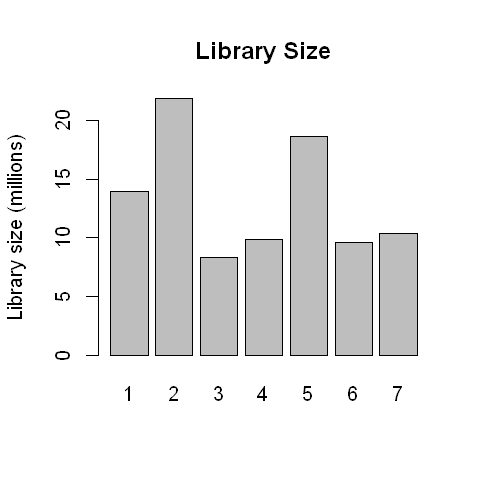

In [211]:
options(repr.plot.width=4, repr.plot.height=4)
barplot(y2$samples$lib.size*1e-6, names=1:7, ylab="Library size (millions)", main="Library Size")

In [212]:
y2 <- calcNormFactors(y2, method="TMM")

## Estimating dispersion/biological variability between samples

In DE analysis we are testing the idea that gene expression varies between these groups, control and treatment, and we expect that most of the variation between the samples comes from them being either a control sample or a treatment sample. However, there will always be a certain amount of variability we cannot anticipate but that we can measure. This inherent biological varaibility, also called the biological coefficient of variation or BCV, also varies by the type of sample. In well controlled experiments technical replicates would have smaller BCVs than unrelated, unique individuals.

First, we estimate the dispersion which is the amount of variance in our experiment. This is critical to the analysis because we want genes that appear to be consistently high or low across samples to count more in analysis than genes that vary (which signals possible outlier genes) count less. We have specified that robust=TRUE that we may account for any outlier genes. If there are none, this does not affect estimation. 

We then take the square root of the dispersion to give us the BCV. This check of the BCV serves as a measure of quality control for the analysis. Since our samples are from genetically similar samples, we would expect our BCV to be between 0.05-0.2.

[1] 0.1487763

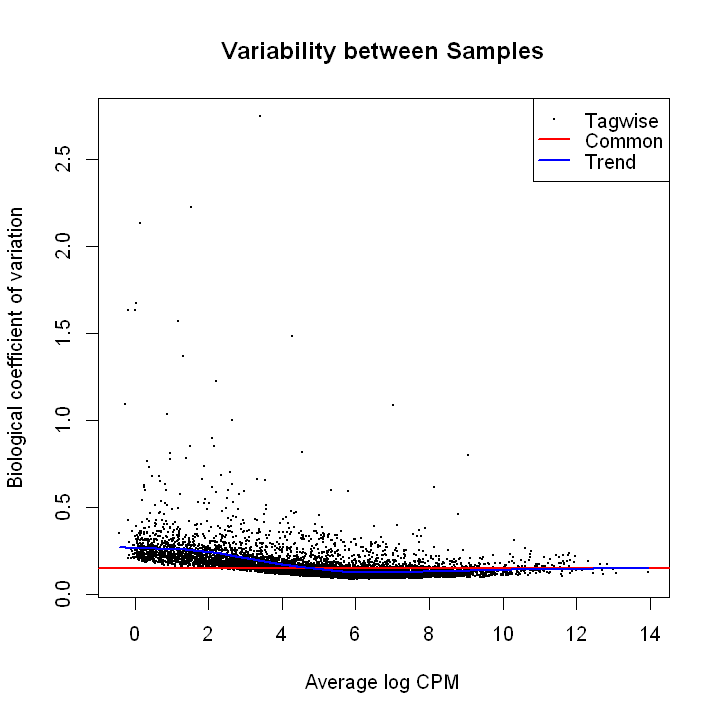

In [213]:
y2=estimateDisp(y2,design, robust=TRUE)
bcv<-sqrt(y2$common.dispersion)
bcv
options(repr.plot.width=6, repr.plot.height=6)
plotBCV(y2, main="Variability between Samples")

Our biological variability is estimated to be 0.14 which makes sense for genetically similar individuals.

## Perform Pairwise Differential Expression Analysis

At this point we have prepared all of the data to be input into our quasi- likelihood F (QLF) test. Recall that the hypothesis we are testing is that there is no difference in gene expression between the treatment and control samples. We chose to use the QLF test because of all of the tests edgeR offers, it is the most up to date as of writing this and gives us the strongest control of false postive results. In this step we specify our comparison of interests, treated to untreated, we fit the QLF model, test it, and summarize our results.

Since in our example we have an idea of what we're expecting to find in terms of the number of DE genes, we want to be sure we have as few false positive DE genes as possible so that we know whichever we do see, we can confidently follow up on with a lab test. 

The decision to use edgeR will vary by your experimental goals. If you use edgeR, the QLF test is always the recommended test because even if you are doing a simple pairwise comparsion now, you can add in additional variables like sex, ethnicity, or batch with relative ease as compared to the other tests available. Please contact EICC if you would like to discuss your experimental goals so we can assist you in choosing the appropriate analysis tool.

In [153]:
comparison <- makeContrasts(treated-untreated, levels=design)

qlfit <-glmQLFit(y2, design, robust=TRUE)
qlf <- glmQLFTest(qlfit, contrast=comparison)
summary(decideTests(qlf, adjust.method="fdr", p.value=0.05)) 

       -1*untreated 1*treated
Down                      337
NotSig                   7224
Up                        358

In this example we see that while controlling the adjustedp/FDR threshold at <0.05, we have 695 (9.6%) DE genes. Of these, 358 (4.9%) are up regulated and 337 (4.7%) are down regulated while 7224 (91%) are not significantly differentially expressed.

In our walkthorugh of DESEq2 we use the same example dataset and found that while controlling the adjustedp/FDR threshold at <0.1, we had 1,054 (10.6%) DE genes. Of these, 518 (5.2%) were up regulated and 536 (5.4%) were down regulated. There was 1 outlier gene (0.01%) detected and 1539 genes (16%) with low counts were removed for having counts <6 across all samples. Different analytical tools will often give you slightly different results and edgeR may be better for projects which have specified genes of interest in mind rather than exploratory projects since edgeR is much more strict with potential false positive results while DESeq2 may allow more false positives into your significant results but it provides you additional tools for evaluating their veracity before following up with a lab test.

FDR thresholds can also range from 0.05-0.2 and it is much better to have the option to lower your threshold during analysis rather than have to increase it because your study was not sufficiently powered to find anything but the most extremely highly or lowly differentially expressed genes. Please reach out to us at EICC if you would like assistance in planning your experimental design for your RNAseq project and in setting appropriate FDR thresholds.

## Visualization

edgeR offers a number of visualization options to assess your findings and below we have summarized a few examples available to you.

###### PCA plot

To see how much membership in either the control or treatment group contributes to the differences in their genetic expression, we use a PCA plot. By default, edgeR produces a general multi-dimensional scaling plot that tells us how closely related the samples are to each other by log fold changes. We can specify that we would like to view the special case of a PCA plot which tells us how much group membership (i.e. being untreated or treated) contributes to the differences between the samples and we hope this will be high. 

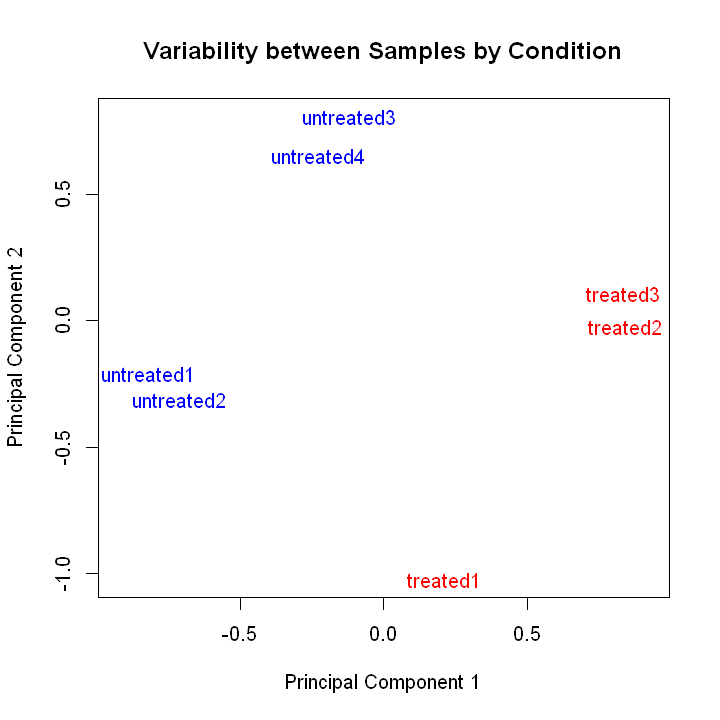

In [174]:
options(repr.plot.width=6, repr.plot.height=6)
colors <- rep(c("red", "blue"), 2)
plotMDS.DGEList(y, col=colors[group], gene.selection="common", main="Variability between Samples by Condition")

This is a great looking PCA plot because it shows that it is our samples are clustered by so we can say that the experimental condition is largely responsible for the variation between the samples rather than noise generated by sequencing, analysis, or some other unaccounted for variable.

###### MA plot

The MA plot shows us the condensed log2 fold changes without the noise generated by genes with low counts.

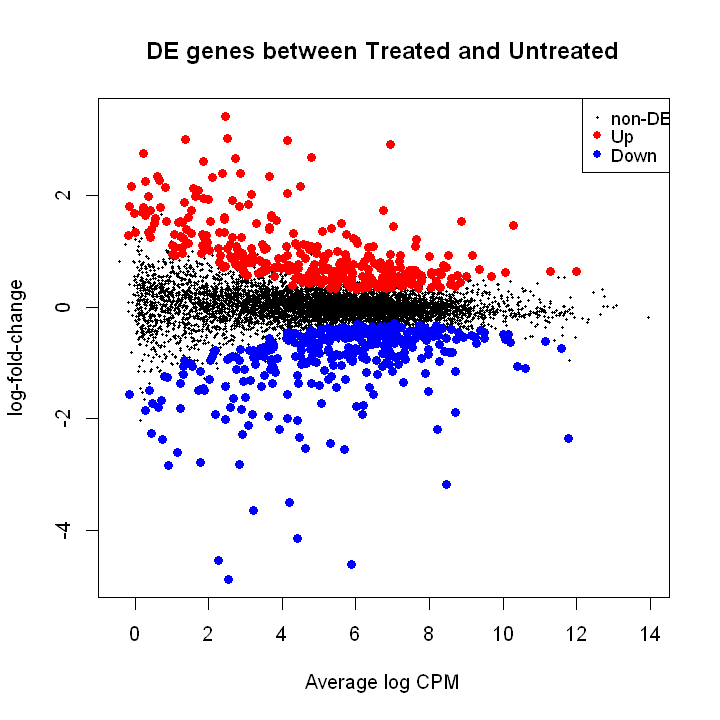

In [175]:
options(repr.plot.width=6, repr.plot.height=6)
plotMD(qlf, main="DE genes between Treated and Untreated")

###### Heatmap

Before we generate our heatmap in edgeR, we need to transform the counts in the DGEList object y) into counts per million (CPM) and then log transform them. In this example we have decided to sort the DE genes by smallest adjusted p value and only examine the top 20 DE genes. The number of DE genes you may want to visualize is customizable based on your project with EICC.

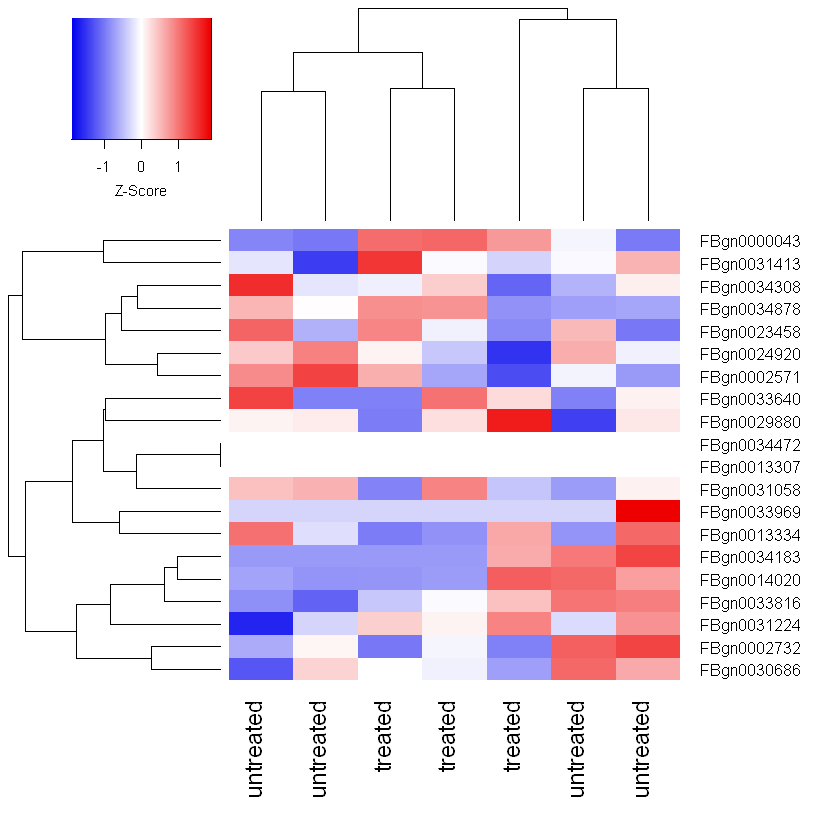

In [188]:
logCPM <- cpm(y, prior.count=2, log=TRUE)
rownames(logCPM) <- rownames(x)
colnames(logCPM) <- paste(y$samples$group, sep="-")
o <- order(qlf$table$PValue)
logCPM <- logCPM[o[1:20],]
coolmap(logCPM, margins=c(8,8))

There are many more functions and many more specifications to functions than are used here in order to show a simplified example of one of the tools we use for differential expression analysis. Obtaining specific, actionable, and publication quality results from analysis requires a deeper understanding of your specific data set and we would love the opportunity to discuss these options with you.

While we encourage clients to reach out prior to sequencing so that we can collaborate to design the experiment to answer your specific questions, we look forward to hearing from you at any stage of your RNAseq project. Please find our contact information available here https://www.cores.emory.edu/eicc/about/index.html

In [189]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18362)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.24.0               SummarizedExperiment_1.14.1
 [3] DelayedArray_0.10.0         BiocParallel_1.18.1        
 [5] matrixStats_0.55.0          Biobase_2.44.0             
 [7] GenomicRanges_1.36.0        GenomeInfoDb_1.20.0        
 [9] IRanges_2.18.1              S4Vectors_0.22.0           
[11] BiocGenerics_0.30.0         ggplot2_3.2.1              
[13] pasilla_1.12.0              edgeR_3.26.6               
[15] limma_3.40.5               

loaded via a namespace (a